In [ ]:
%reset

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [140]:
data = pd.read_csv('./company_stock_prices/MSFT.csv', 
                    header=0, 
                    usecols=['Date', 'Close'], 
                    parse_dates=True, 
                    index_col= 'Date')

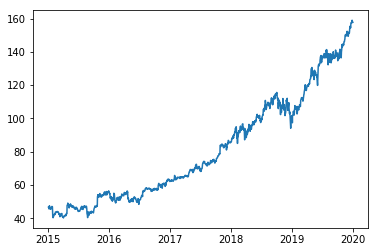

In [141]:
plt.plot(data['Close'])
plt.show()

In [165]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [143]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
# print(scaled_data)

In [144]:
# 70-30 split
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [145]:
def create_dataset(dataset, timestep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep - 1):
        data_x.append(dataset[i: (i+timestep), 0])
        data_y.append(dataset[i + timestep, 0])
    return np.array(data_x), np.array(data_y)

In [146]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

In [147]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [148]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [149]:
def create_model():
    model = Sequential()
    model.add(LSTM(256, input_shape=(1,1)))
    model.add(Dense(1,activation='sigmoid'))  
    return model

In [150]:
def compile_and_run(model, epochs, batch_size):
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(train_x, train_y, verbose=1)
    return history, score

In [151]:
def plot_metrics(history):
    metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
    metrics_df.plot()

In [152]:
LSTM_model = create_model()
print(LSTM_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None


In [153]:
history, score = compile_and_run(LSTM_model, epochs=100, batch_size=32) 
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0988 - accuracy: 0.0011
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0636 - accuracy: 0.0011
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0362 - accuracy: 0.0011
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0264 - accuracy: 0.0011
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0226 - accuracy: 0.0011
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0197 - accuracy: 0.0011
Epoch 7/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0170 - accuracy: 0.0011
Epoch 8/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0143 - accuracy: 0.0011
Epoch 9/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0117 - accuracy: 0.0011
Epoch 10/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0092 - accuracy: 0.0011
Epoch 11/

In [154]:
train_predictions = LSTM_model.predict(train_x)
test_predictions = LSTM_model.predict(test_x)

In [155]:
train_predictions = scaler.inverse_transform(train_predictions)
train_y = scaler.inverse_transform([train_y])

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

In [156]:
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:,:] = np.nan
train_predict_plot[1:len(train_predictions)+1, :] = train_predictions

In [157]:
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predictions)+2+1 : len(scaled_data)-1, :] = test_predictions

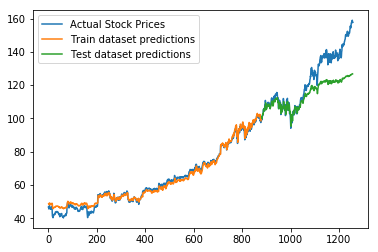

In [158]:
actual_stock_prices, = plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Prices')
train_dataset_prediction, = plt.plot(train_predict_plot, label='Train dataset predictions')
test_dataset_prediction, = plt.plot(test_predict_plot, label='Test dataset predictions')
plt.legend(handles = [actual_stock_prices, train_dataset_prediction, test_dataset_prediction])
plt.show()

In [159]:
test_array = scaler.inverse_transform(scaled_data).flatten()
test_array = test_array[int(len(scaled_data)*0.7+2):int(len(scaled_data))]

test_prediction_flattened = test_predictions.flatten()
df = pd.DataFrame({'Actual Values':test_array, 'Predicted Values':test_prediction_flattened})

In [172]:
def get_error_scores(y_test,y_pred):
  mse = mean_squared_error(y_test,y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  mae = mean_absolute_error(y_test, y_pred)
  return mse, rmse, mae

In [173]:
mse, rmse, mae = get_error_scores(test_array, test_prediction_flattened)

TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [171]:
print('Mean Squared Error: %.3f' % mse)
print('Root Mean Squared Error: %.3f' % rmse)
print('Mean Average Error: %.3f' % mae)

Mean Squared Error: 151.490
Mean Average Error: 9.048
